In [1]:
%%capture
!pip install scikit-optimize catboost optuna

In [2]:
# After running
! git clone --recursive https://github.com/Microsoft/LightGBM

#You can run this oneliner which will build and compile LightGBM with GPU enabled in colab:
! cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;

Cloning into 'LightGBM'...
remote: Enumerating objects: 29073, done.
remote: Counting objects: 100% (325/325), done.
remote: Compressing objects: 100% (199/199), done.
remote: Total 29073 (delta 167), reused 214 (delta 124), pack-reused 28748
Receiving objects: 100% (29073/29073), 20.66 MiB | 33.95 MiB/s, done.
Resolving deltas: 100% (21501/21501), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/LightGBM/external_libs/compute'...
remote: Enumerating objects: 21733, done.        
remote: Counting objects: 100% (5/5), done.        
remote: Co

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/kaggle/WiDS

%load_ext autoreload
%autoreload 2

/content/drive/MyDrive/kaggle/WiDS


In [3]:
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', 40)
pd.set_option('display.max_rows', 100)

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

import os
import sys
from datetime import datetime
import gc

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import uniform, randint, iqr
from skopt import BayesSearchCV
from skopt.space import Real, Integer

from catboost import CatBoostRegressor
import xgboost as xgb
import lightgbm as lgb
import optuna

import warnings; warnings.filterwarnings('ignore')

sys.path.append('..')
from config import CFG
from src.data_processing.reduce_mem import reduce_mem_usage
CFG = CFG()

In [4]:
BASE_PATH = os.getcwd()
DATA_PATH = os.path.join(BASE_PATH, 'data')
RAW_DATA_PATH = os.path.join(DATA_PATH, 'raw')

CFG.DATA_PATH = DATA_PATH
CFG.RAW_DATA_PATH = RAW_DATA_PATH
CFG.BASE_PATH = BASE_PATH

In [5]:
cc_train = pd.read_csv(os.path.join(CFG.RAW_DATA_PATH, 'train_data.csv'), parse_dates=["startdate"])
cc_test = pd.read_csv(os.path.join(CFG.RAW_DATA_PATH, 'test_data.csv'), parse_dates=["startdate"])
cc_sample = pd.read_csv(os.path.join(CFG.DATA_PATH, 'sample_solution.csv'))
target = 'contest-tmp2m-14d__tmp2m'

In [6]:
cc_train = reduce_mem_usage(cc_train)

Mem. usage decreased to 352.24 Mb (50.1% reduction)


In [7]:
train_df = cc_train.copy()
test_df = cc_test.copy()

In [8]:
def remove_outliers_tukey(data, alpha=1.5):
    '''
    Remove outliers using Tukey's method with the interquartile range (IQR).
    
    Parameters:
    data (numpy array or pandas dataframe): The data to remove outliers from.
    alpha (float): The sensitivity parameter, which determines the range to consider outliers.
                   A value of 1.5 is the default, which is a commonly used value.
    
    Returns:
    numpy array or pandas dataframe: The data with outliers removed.
    '''
    # Select only the numerical columns
    num_cols = data.select_dtypes(include=[np.number]).columns
    data_num = data[num_cols]
    
    # Compute the first and third quartiles
    q1, q3 = np.percentile(data_num, [25, 75])
    
    # Compute the interquartile range (IQR)
    iqr_val = iqr(data_num)
    
    # Compute the range outside of which data points are considered outliers
    outlier_range = (q1 - alpha * iqr_val, q3 + alpha * iqr_val)
    
    # Identify the outliers and remove them
    outliers = (data_num < outlier_range[0]) | (data_num > outlier_range[1])
    data_num_no_outliers = data_num[~outliers]
    
    # Merge the numerical columns back into the original data frame
    data_no_outliers = pd.concat([data_num_no_outliers, data.select_dtypes(exclude=[np.number])], axis=1)
    
    return data_no_outliers

data_with_removed_outliers = remove_outliers_tukey(train_df)
data_with_removed_outliers.shape

(375734, 246)

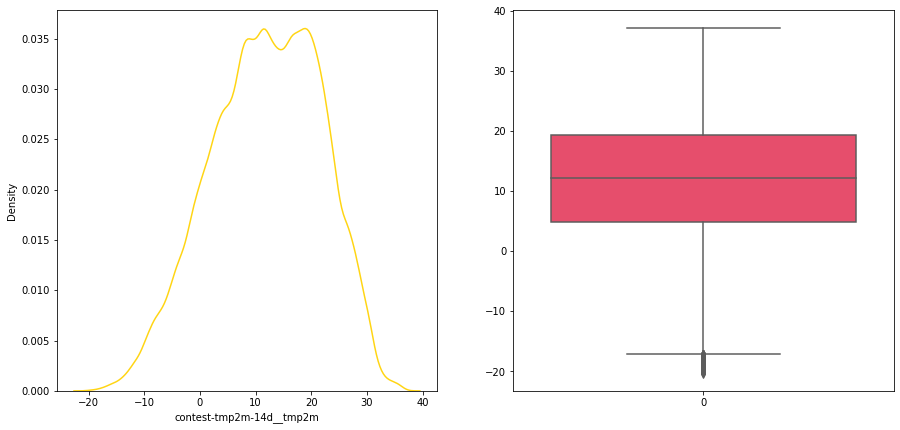

In [9]:
def target_var_visualized():
  plt.figure(figsize=(15,7))
  plt.subplot(121)
  sb.kdeplot(cc_train['contest-tmp2m-14d__tmp2m'], color = "#ffd514")
  plt.subplot(122)
  sb.boxplot(data=cc_train['contest-tmp2m-14d__tmp2m'], color = "#ff355d")
target_var_visualized()

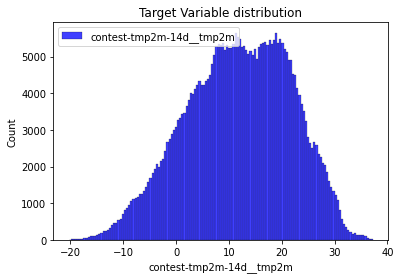

In [10]:
def histogram_plot(data, label, title):
    sb.histplot(data, color='blue', label=label)
    plt.legend()
    plt.title(title)
    plt.show()
histogram_plot(data=cc_train['contest-tmp2m-14d__tmp2m'], label="contest-tmp2m-14d__tmp2m", title="Target Variable distribution")

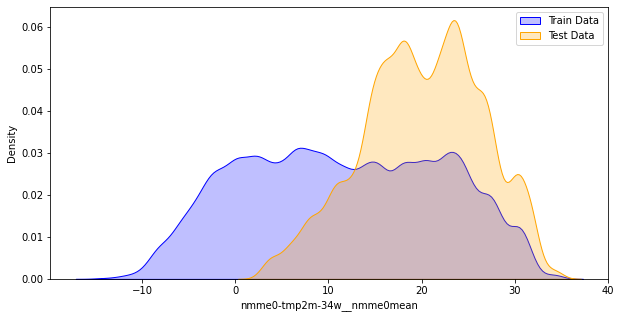

In [11]:
def train_test_dist(train, test):
    fig, ax = plt.subplots(figsize = (10, 5))
    sb.kdeplot(data=train,  color='blue', fill=True, ax=ax, label="Train Data")
    sb.kdeplot(data=test, color='orange', fill=True, ax=ax, label="Test Data")
    plt.legend()
    plt.show()
    
#train_target = cc_train['contest-tmp2m-14d__tmp2m']
#test_target = cc_test['contest-tmp2m-14d__tmp2m']
train_target = cc_train['nmme0-tmp2m-34w__nmme0mean']
test_target = cc_test['nmme0-tmp2m-34w__nmme0mean']
train_test_dist(train_target, test_target)

In [12]:
def location_feature(train, test):
    # Reference: https://www.kaggle.com/code/flaviafelicioni/wids-2023-different-locations-train-test-solved
    scale = 14
    train.loc[:,'lat']=round(train.lat,scale)
    train.loc[:,'lon']=round(train.lon,scale)
    test.loc[:,'lat']=round(test.lat,scale)
    test.loc[:,'lon']=round(test.lon,scale)
    
    train_and_test = pd.concat([train, test], axis=0)
    train_and_test['loc_group'] = train_and_test.groupby(['lat', 'lon']).ngroup()
    print(f'{train_and_test.loc_group.nunique()} unique locations')
    
    train = train_and_test.iloc[:len(train)]
    test = train_and_test.iloc[len(train):].drop(target, axis=1)
    
    return train, test

def cat_encode(train, test):
    # encoding the categorical feature in the train and test data set
    # using OneHotEncoder
    le = LabelEncoder()
    train['climateregions__climateregion'] = le.fit_transform(train['climateregions__climateregion'])
    test['climateregions__climateregion'] = le.transform(test['climateregions__climateregion'])
    
    # train = train.drop(['climateregions__climateregion'], axis=1)
    # test = test.drop(['climateregions__climateregion'], axis=1)
    
    # train_encoded = pd.DataFrame(train_encoded.toarray(), columns=ohe.get_feature_names_out(['climateregions__climateregion']))
    # test_encoded = pd.DataFrame(test_encoded.toarray(), columns=ohe.get_feature_names_out(['climateregions__climateregion']))
    
    # train = pd.concat([train, train_encoded], axis=1)
    # test = pd.concat([test, test_encoded], axis=1)
    
    return train, test

def fill_na_rows(dataset):
    # Find the columns with missing values
    columns_with_missing_values = dataset.columns[dataset.isnull().any()].tolist()
    
    # Impute the missing values with the mean value of that column
    for col in columns_with_missing_values:
        dataset[col].fillna(dataset[col].mean(), inplace=True)
        
    return dataset

def create_new_feat(dataset):
    dataset['year']=dataset['startdate'].dt.year 
    dataset['month']=dataset['startdate'].dt.month 
    dataset['day']=dataset['startdate'].dt.dayofyear
    return dataset

def feature_engineering(origin_train, origin_test):
    train, test = origin_train, origin_test
    train = fill_na_rows(train)
    train = create_new_feat(train)
    test = create_new_feat(test)
    train, test = cat_encode(train, test)
    irrelevant_cols = ['index', 'startdate','contest-tmp2m-14d__tmp2m', 'climateregions__climateregion']
    features = [col for col in train.columns if col not in irrelevant_cols]
    X = train[features]
    X_test = test[features]
    y = train['contest-tmp2m-14d__tmp2m']
    
    return X, y, X_test

In [13]:
X, y, X_test = feature_engineering(cc_train.copy(), cc_test.copy())

In [14]:
## Identify correlated features to drop that fall above a correlation threshold 
## https://goodboychan.github.io/python/datacamp/machine_learning/2020/07/08/02-Feature-selection-I-selecting-for-feature-information.html 

def identify_correlated(df, threshold):
    corr_matrix = df.corr().abs()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    reduced_corr_matrix = corr_matrix.mask(mask)
    features_to_drop = [c for c in reduced_corr_matrix.columns if any(reduced_corr_matrix[c] > threshold)]
    return features_to_drop

features_to_drop = identify_correlated(cc_train, .80)

In [15]:
print(len(features_to_drop))
print(features_to_drop)

100
['index', 'contest-pevpr-sfc-gauss-14d__pevpr', 'nmme0-tmp2m-34w__cancm30', 'nmme0-tmp2m-34w__cancm40', 'nmme0-tmp2m-34w__ccsm30', 'nmme0-tmp2m-34w__ccsm40', 'nmme0-tmp2m-34w__cfsv20', 'nmme0-tmp2m-34w__gfdlflora0', 'nmme0-tmp2m-34w__gfdlflorb0', 'nmme0-tmp2m-34w__gfdl0', 'nmme0-tmp2m-34w__nasa0', 'nmme0-tmp2m-34w__nmme0mean', 'contest-wind-h10-14d__wind-hgt-10', 'nmme-tmp2m-56w__cancm3', 'nmme-tmp2m-56w__cancm4', 'nmme-tmp2m-56w__ccsm3', 'nmme-tmp2m-56w__ccsm4', 'nmme-tmp2m-56w__cfsv2', 'nmme-tmp2m-56w__gfdl', 'nmme-tmp2m-56w__gfdlflora', 'nmme-tmp2m-56w__gfdlflorb', 'nmme-tmp2m-56w__nasa', 'nmme-tmp2m-56w__nmmemean', 'nmme-prate-34w__cancm3', 'nmme-prate-34w__cancm4', 'nmme-prate-34w__ccsm3', 'nmme-prate-34w__ccsm4', 'nmme-prate-34w__cfsv2', 'nmme-prate-34w__gfdl', 'nmme-prate-34w__gfdlflora', 'nmme-prate-34w__gfdlflorb', 'nmme-prate-34w__nasa', 'nmme-prate-34w__nmmemean', 'contest-wind-h100-14d__wind-hgt-100', 'nmme0-prate-56w__cancm30', 'nmme0-prate-56w__cancm40', 'nmme0-prate-

In [16]:
remove_feature = ['index', 'contest-tmp2m-14d__tmp2m']
features_to_drop_v1 = [ele for ele in features_to_drop if ele not in remove_feature]
features_to_drop_v1

['contest-pevpr-sfc-gauss-14d__pevpr',
 'nmme0-tmp2m-34w__cancm30',
 'nmme0-tmp2m-34w__cancm40',
 'nmme0-tmp2m-34w__ccsm30',
 'nmme0-tmp2m-34w__ccsm40',
 'nmme0-tmp2m-34w__cfsv20',
 'nmme0-tmp2m-34w__gfdlflora0',
 'nmme0-tmp2m-34w__gfdlflorb0',
 'nmme0-tmp2m-34w__gfdl0',
 'nmme0-tmp2m-34w__nasa0',
 'nmme0-tmp2m-34w__nmme0mean',
 'contest-wind-h10-14d__wind-hgt-10',
 'nmme-tmp2m-56w__cancm3',
 'nmme-tmp2m-56w__cancm4',
 'nmme-tmp2m-56w__ccsm3',
 'nmme-tmp2m-56w__ccsm4',
 'nmme-tmp2m-56w__cfsv2',
 'nmme-tmp2m-56w__gfdl',
 'nmme-tmp2m-56w__gfdlflora',
 'nmme-tmp2m-56w__gfdlflorb',
 'nmme-tmp2m-56w__nasa',
 'nmme-tmp2m-56w__nmmemean',
 'nmme-prate-34w__cancm3',
 'nmme-prate-34w__cancm4',
 'nmme-prate-34w__ccsm3',
 'nmme-prate-34w__ccsm4',
 'nmme-prate-34w__cfsv2',
 'nmme-prate-34w__gfdl',
 'nmme-prate-34w__gfdlflora',
 'nmme-prate-34w__gfdlflorb',
 'nmme-prate-34w__nasa',
 'nmme-prate-34w__nmmemean',
 'contest-wind-h100-14d__wind-hgt-100',
 'nmme0-prate-56w__cancm30',
 'nmme0-prate-56w__ca

In [17]:
cc_train_reduced = pd.DataFrame(X.drop(features_to_drop_v1, axis=1))
cc_test_reduced = pd.DataFrame(X_test.drop(features_to_drop_v1, axis=1))
print("Dropped features that are highly correlated")

Dropped features that are highly correlated


In [18]:
X_train, X_test_tts, y_train, y_test = train_test_split(cc_train_reduced, y, test_size=0.33, random_state=42)
print("Split the dataset for training successfully")

Split the dataset for training successfully


In [19]:
cc_test_copy = cc_test.copy()

In [23]:
# create a DMatrix from the training data
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test)

# set up parameters for XGBoost
# list of learning_rates to test [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
# n_estimators = [50, 100, 150, 200]
# max_depth = [2, 4, 6, 8]
# param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
print("Training and predicting using xgboost")
# Define the search space for the hyperparameters
params = {'base_score': 0.5, 
          'booster': 'gbtree',
          'tree_method': 'gpu_hist',
          'n_estimators': 15000,
          'objective': 'reg:squarederror',
          'max_depth': 6,
          'subsample': 0.5,
          'colsample_bytree': 0.5,
          'gamma': 1.4,
          'min_child_weight': 7,
          'learning_rate': 0.01,
          'gpu_id': 0}

reg_xgb = xgb.XGBRegressor(**params)

reg_xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test_tts, y_test)], verbose=1000)

# get the feature importance scores
importance_scores = reg_xgb.feature_importances_
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': importance_scores})
feature_importances.to_csv("xgboostbestparameters.csv")
# sort the features by importance score
feature_importances = feature_importances.sort_values('importance', ascending=False)
print(feature_importances)


# make predictions on the test data
y_pred_xgb = reg_xgb.predict(X_test_tts)

# calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print("RMSE:", rmse)


cc_test_pred = reg_xgb.predict(cc_test_reduced)
cc_test_copy[target] = cc_test_pred
cc_test_copy[[target,"index"]].to_csv("xgbpredictions.csv",index = False)
print("Finished training and fitting, created xgbpredictions,csv")

Training and predicting using xgboost
[0]	validation_0-rmse:14.9089	validation_1-rmse:14.8861
[1000]	validation_0-rmse:0.994756	validation_1-rmse:1.0128
[2000]	validation_0-rmse:0.806167	validation_1-rmse:0.832438
[3000]	validation_0-rmse:0.707511	validation_1-rmse:0.740375
[4000]	validation_0-rmse:0.636678	validation_1-rmse:0.675306
[5000]	validation_0-rmse:0.581393	validation_1-rmse:0.625062
[6000]	validation_0-rmse:0.534665	validation_1-rmse:0.582464
[7000]	validation_0-rmse:0.497865	validation_1-rmse:0.549465
[8000]	validation_0-rmse:0.467725	validation_1-rmse:0.522745
[9000]	validation_0-rmse:0.442999	validation_1-rmse:0.501176
[10000]	validation_0-rmse:0.419925	validation_1-rmse:0.480982
[11000]	validation_0-rmse:0.399659	validation_1-rmse:0.463345
[12000]	validation_0-rmse:0.382493	validation_1-rmse:0.448664
[13000]	validation_0-rmse:0.368047	validation_1-rmse:0.4366
[14000]	validation_0-rmse:0.354433	validation_1-rmse:0.425152
[14999]	validation_0-rmse:0.342334	validation_1-rms

In [24]:
def objective(trial):
    gc.collect()
    params = {
        'base_score': 0.5, 
        'booster': 'gbtree',
        'tree_method': 'gpu_hist',
        'n_estimators': 6000,
        'objective': 'reg:squarederror',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1.0),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'verbosity': 0,
        'gpu_id': 0
    }

    reg_xgb = xgb.XGBRegressor(**params)

    reg_xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test_tts, y_test)], verbose=1000)

    y_pred_xgb = reg_xgb.predict(X_test_tts)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15)

print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial

print(f'  Value: {trial.value:.5f}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

best_params = trial.params
reg_xgb = xgb.XGBRegressor(**best_params)
reg_xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test_tts, y_test)])
y_pred_xgb = reg_xgb.predict(X_test_tts)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print("RMSE:", rmse)

cc_test_pred = reg_xgb.predict(cc_test_reduced)
cc_test_copy[target] = cc_test_pred
cc_test_copy[[target,"index"]].to_csv("xgbpredictions.csv",index = False)
print("Finished training and fitting, created xgbpredictions.csv")

[I 2023-02-23 01:03:49,169] A new study created in memory with name: no-name-6d9fcb33-2b8e-44c4-8972-ddd564aae8ef


[0]	validation_0-rmse:14.643	validation_1-rmse:14.6209
[1000]	validation_0-rmse:1.07939	validation_1-rmse:1.1041
[2000]	validation_0-rmse:0.896443	validation_1-rmse:0.932612
[3000]	validation_0-rmse:0.799695	validation_1-rmse:0.843947
[4000]	validation_0-rmse:0.722303	validation_1-rmse:0.773219
[5000]	validation_0-rmse:0.667444	validation_1-rmse:0.724366
[5999]	validation_0-rmse:0.623158	validation_1-rmse:0.685472


[I 2023-02-23 01:05:46,288] Trial 0 finished with value: 0.6854723691940308 and parameters: {'max_depth': 5, 'subsample': 0.6910476945204058, 'colsample_bytree': 0.13515777082102853, 'learning_rate': 0.02892273857372606}. Best is trial 0 with value: 0.6854723691940308.


[0]	validation_0-rmse:15.0463	validation_1-rmse:15.0232
[1000]	validation_0-rmse:9.0553	validation_1-rmse:9.04423
[2000]	validation_0-rmse:5.50002	validation_1-rmse:5.49988
[3000]	validation_0-rmse:3.40134	validation_1-rmse:3.41281
[4000]	validation_0-rmse:2.17803	validation_1-rmse:2.20243
[5000]	validation_0-rmse:1.48002	validation_1-rmse:1.51834
[5999]	validation_0-rmse:1.09062	validation_1-rmse:1.14229


[I 2023-02-23 01:17:07,735] Trial 1 finished with value: 1.142287254333496 and parameters: {'max_depth': 10, 'subsample': 0.5871515524700076, 'colsample_bytree': 0.9247631145138844, 'learning_rate': 0.0005207504919322584}. Best is trial 0 with value: 0.6854723691940308.


[0]	validation_0-rmse:15.0465	validation_1-rmse:15.0234
[1000]	validation_0-rmse:9.44531	validation_1-rmse:9.43304
[2000]	validation_0-rmse:6.1528	validation_1-rmse:6.14965
[3000]	validation_0-rmse:4.2501	validation_1-rmse:4.254
[4000]	validation_0-rmse:3.16768	validation_1-rmse:3.17653
[5000]	validation_0-rmse:2.55792	validation_1-rmse:2.5689
[5999]	validation_0-rmse:2.20837	validation_1-rmse:2.2195


[I 2023-02-23 01:18:54,037] Trial 2 finished with value: 2.2194952964782715 and parameters: {'max_depth': 4, 'subsample': 0.34140823219305677, 'colsample_bytree': 0.28770022719237337, 'learning_rate': 0.0005281767773693531}. Best is trial 0 with value: 0.6854723691940308.


[0]	validation_0-rmse:15.0506	validation_1-rmse:15.0275
[1000]	validation_0-rmse:12.099	validation_1-rmse:12.0816
[2000]	validation_0-rmse:9.74985	validation_1-rmse:9.73719
[3000]	validation_0-rmse:7.88546	validation_1-rmse:7.87707
[4000]	validation_0-rmse:6.40516	validation_1-rmse:6.40061
[5000]	validation_0-rmse:5.23436	validation_1-rmse:5.23322
[5999]	validation_0-rmse:4.31181	validation_1-rmse:4.31371


[I 2023-02-23 01:22:10,289] Trial 3 finished with value: 4.313712120056152 and parameters: {'max_depth': 7, 'subsample': 0.30109224464158935, 'colsample_bytree': 0.3716941054833396, 'learning_rate': 0.00023061660683875552}. Best is trial 0 with value: 0.6854723691940308.


[0]	validation_0-rmse:15.0171	validation_1-rmse:14.9941
[1000]	validation_0-rmse:1.7675	validation_1-rmse:1.78866
[2000]	validation_0-rmse:0.921468	validation_1-rmse:0.959788
[3000]	validation_0-rmse:0.75287	validation_1-rmse:0.796011
[4000]	validation_0-rmse:0.669573	validation_1-rmse:0.71591
[5000]	validation_0-rmse:0.611004	validation_1-rmse:0.660712
[5999]	validation_0-rmse:0.563889	validation_1-rmse:0.616796


[I 2023-02-23 01:26:49,973] Trial 4 finished with value: 0.61679607629776 and parameters: {'max_depth': 8, 'subsample': 0.9408618878581921, 'colsample_bytree': 0.9728357745098232, 'learning_rate': 0.0025082891096734807}. Best is trial 4 with value: 0.61679607629776.


[0]	validation_0-rmse:14.5351	validation_1-rmse:14.5134
[1000]	validation_0-rmse:1.02821	validation_1-rmse:1.04166
[2000]	validation_0-rmse:0.84474	validation_1-rmse:0.865688
[3000]	validation_0-rmse:0.736065	validation_1-rmse:0.763583
[4000]	validation_0-rmse:0.664058	validation_1-rmse:0.696694
[5000]	validation_0-rmse:0.608446	validation_1-rmse:0.644898
[5999]	validation_0-rmse:0.565916	validation_1-rmse:0.605566


[I 2023-02-23 01:28:28,953] Trial 5 finished with value: 0.6055659055709839 and parameters: {'max_depth': 4, 'subsample': 0.8675803916444161, 'colsample_bytree': 0.8865587502667105, 'learning_rate': 0.03658391771087753}. Best is trial 5 with value: 0.6055659055709839.


[0]	validation_0-rmse:14.9812	validation_1-rmse:14.9583
[1000]	validation_0-rmse:1.42932	validation_1-rmse:1.4387
[2000]	validation_0-rmse:1.20276	validation_1-rmse:1.21367
[3000]	validation_0-rmse:1.07227	validation_1-rmse:1.08622
[4000]	validation_0-rmse:0.985872	validation_1-rmse:1.00243
[5000]	validation_0-rmse:0.920982	validation_1-rmse:0.939687
[5999]	validation_0-rmse:0.870326	validation_1-rmse:0.89103


[I 2023-02-23 01:30:30,882] Trial 6 finished with value: 0.8910301923751831 and parameters: {'max_depth': 5, 'subsample': 0.607127257488215, 'colsample_bytree': 0.8552675325492065, 'learning_rate': 0.005078542849511475}. Best is trial 5 with value: 0.6055659055709839.


[0]	validation_0-rmse:13.8871	validation_1-rmse:13.8663
[1000]	validation_0-rmse:0.196702	validation_1-rmse:0.348594
[2000]	validation_0-rmse:0.117223	validation_1-rmse:0.312396
[3000]	validation_0-rmse:0.079275	validation_1-rmse:0.299807
[4000]	validation_0-rmse:0.05665	validation_1-rmse:0.293703
[5000]	validation_0-rmse:0.041758	validation_1-rmse:0.290459
[5999]	validation_0-rmse:0.031449	validation_1-rmse:0.28849


[I 2023-02-23 01:36:03,864] Trial 7 finished with value: 0.28848981857299805 and parameters: {'max_depth': 9, 'subsample': 0.650372241173411, 'colsample_bytree': 0.638887513612685, 'learning_rate': 0.07926326621542656}. Best is trial 7 with value: 0.28848981857299805.


[0]	validation_0-rmse:14.9993	validation_1-rmse:14.9763
[1000]	validation_0-rmse:1.26608	validation_1-rmse:1.28687
[2000]	validation_0-rmse:0.906901	validation_1-rmse:0.932899
[3000]	validation_0-rmse:0.787597	validation_1-rmse:0.818008
[4000]	validation_0-rmse:0.704809	validation_1-rmse:0.739005
[5000]	validation_0-rmse:0.644656	validation_1-rmse:0.682341
[5999]	validation_0-rmse:0.594592	validation_1-rmse:0.635415


[I 2023-02-23 01:39:13,701] Trial 8 finished with value: 0.6354144811630249 and parameters: {'max_depth': 7, 'subsample': 0.6178594611879689, 'colsample_bytree': 0.7202870746504741, 'learning_rate': 0.00374558425336942}. Best is trial 7 with value: 0.28848981857299805.


[0]	validation_0-rmse:14.8118	validation_1-rmse:14.789
[1000]	validation_0-rmse:0.573594	validation_1-rmse:0.62407
[2000]	validation_0-rmse:0.432008	validation_1-rmse:0.500876
[3000]	validation_0-rmse:0.362779	validation_1-rmse:0.445455
[4000]	validation_0-rmse:0.318055	validation_1-rmse:0.411661
[5000]	validation_0-rmse:0.286019	validation_1-rmse:0.38869
[5999]	validation_0-rmse:0.260648	validation_1-rmse:0.371304


[I 2023-02-23 01:42:56,856] Trial 9 finished with value: 0.3713044822216034 and parameters: {'max_depth': 8, 'subsample': 0.26196999672293325, 'colsample_bytree': 0.5067798233332564, 'learning_rate': 0.016553093890146572}. Best is trial 7 with value: 0.28848981857299805.


[0]	validation_0-rmse:13.6553	validation_1-rmse:13.6347
[1000]	validation_0-rmse:0.312392	validation_1-rmse:0.50851
[2000]	validation_0-rmse:0.220268	validation_1-rmse:0.480419
[3000]	validation_0-rmse:0.166981	validation_1-rmse:0.468526
[4000]	validation_0-rmse:0.131233	validation_1-rmse:0.461345
[5000]	validation_0-rmse:0.104957	validation_1-rmse:0.457048
[5999]	validation_0-rmse:0.085507	validation_1-rmse:0.454062


[I 2023-02-23 01:50:02,260] Trial 10 finished with value: 0.4540618658065796 and parameters: {'max_depth': 10, 'subsample': 0.13032731883564214, 'colsample_bytree': 0.6581632929293972, 'learning_rate': 0.09552335588099693}. Best is trial 7 with value: 0.28848981857299805.


[0]	validation_0-rmse:14.7637	validation_1-rmse:14.741
[1000]	validation_0-rmse:0.403121	validation_1-rmse:0.481123
[2000]	validation_0-rmse:0.275843	validation_1-rmse:0.377457
[3000]	validation_0-rmse:0.218792	validation_1-rmse:0.336681
[4000]	validation_0-rmse:0.182514	validation_1-rmse:0.312878
[5000]	validation_0-rmse:0.156385	validation_1-rmse:0.296922
[5999]	validation_0-rmse:0.136986	validation_1-rmse:0.285723


[I 2023-02-23 01:55:09,493] Trial 11 finished with value: 0.28572341799736023 and parameters: {'max_depth': 9, 'subsample': 0.4262544921933473, 'colsample_bytree': 0.5182471785787539, 'learning_rate': 0.01973912204062833}. Best is trial 11 with value: 0.28572341799736023.


[0]	validation_0-rmse:14.1806	validation_1-rmse:14.1586
[1000]	validation_0-rmse:0.248656	validation_1-rmse:0.376495
[2000]	validation_0-rmse:0.164341	validation_1-rmse:0.33063
[3000]	validation_0-rmse:0.12114	validation_1-rmse:0.312179
[4000]	validation_0-rmse:0.093787	validation_1-rmse:0.302487
[5000]	validation_0-rmse:0.074474	validation_1-rmse:0.296439
[5999]	validation_0-rmse:0.060529	validation_1-rmse:0.292504


[I 2023-02-23 02:00:21,161] Trial 12 finished with value: 0.2925039827823639 and parameters: {'max_depth': 9, 'subsample': 0.43984273692482884, 'colsample_bytree': 0.5555917501516975, 'learning_rate': 0.05941977007726789}. Best is trial 11 with value: 0.28572341799736023.


[0]	validation_0-rmse:13.6933	validation_1-rmse:13.672
[1000]	validation_0-rmse:0.203708	validation_1-rmse:0.368911
[2000]	validation_0-rmse:0.124829	validation_1-rmse:0.337426
[3000]	validation_0-rmse:0.085622	validation_1-rmse:0.326102
[4000]	validation_0-rmse:0.061319	validation_1-rmse:0.320566
[5000]	validation_0-rmse:0.045359	validation_1-rmse:0.317341
[5999]	validation_0-rmse:0.034174	validation_1-rmse:0.315406


[I 2023-02-23 02:05:56,889] Trial 13 finished with value: 0.3154055178165436 and parameters: {'max_depth': 9, 'subsample': 0.4877860502213721, 'colsample_bytree': 0.7169177853662776, 'learning_rate': 0.09260740598054429}. Best is trial 11 with value: 0.28572341799736023.


[0]	validation_0-rmse:14.8358	validation_1-rmse:14.8131
[1000]	validation_0-rmse:0.438043	validation_1-rmse:0.510254
[2000]	validation_0-rmse:0.300038	validation_1-rmse:0.39257
[3000]	validation_0-rmse:0.233089	validation_1-rmse:0.340043
[4000]	validation_0-rmse:0.191455	validation_1-rmse:0.309817
[5000]	validation_0-rmse:0.160994	validation_1-rmse:0.28837
[5999]	validation_0-rmse:0.138525	validation_1-rmse:0.273453


[I 2023-02-23 02:11:09,616] Trial 14 finished with value: 0.27345263957977295 and parameters: {'max_depth': 9, 'subsample': 0.754944180176617, 'colsample_bytree': 0.4624259037115062, 'learning_rate': 0.014802756054654852}. Best is trial 14 with value: 0.27345263957977295.


Number of finished trials: 15
Best trial:
  Value: 0.27345
  Params: 
    max_depth: 9
    subsample: 0.754944180176617
    colsample_bytree: 0.4624259037115062
    learning_rate: 0.014802756054654852
[02:11:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:14.8357	validation_1-rmse:14.8131
[1]	validation_0-rmse:14.6217	validation_1-rmse:14.5997
[2]	validation_0-rmse:14.4098	validation_1-rmse:14.3881
[3]	validation_0-rmse:14.2022	validation_1-rmse:14.1811
[4]	validation_0-rmse:13.9984	validation_1-rmse:13.9778
[5]	validation_0-rmse:13.7967	validation_1-rmse:13.7766
[6]	validation_0-rmse:13.6006	validation_1-rmse:13.581
[7]	validation_0-rmse:13.4045	validation_1-rmse:13.3853
[8]	validation_0-rmse:13.2122	validation_1-rmse:13.1934
[9]	validation_0-rmse:13.0225	validation_1-rmse:13.0042
[10]	validation_0-rmse:12.8343	validation_1-rmse:12.8163
[11]	validation_0-rmse:12.6499	validation_1-rmse:12.6322

In [20]:
from catboost import CatBoostRegressor
params = {'iterations': 15000,
          'learning_rate': 0.01,
          'depth': 6,
          'l2_leaf_reg': 3,
          'bagging_temperature': 1,
          'border_count': 256,
          'loss_function': 'RMSE',
          'random_seed': None,
          'task_type': 'GPU',
          'verbose': 100}
# Define the CatBoostRegressor object
reg_catboost = CatBoostRegressor(**params)

# Fit the model to the training data
reg_catboost.fit(X_train, y_train, eval_set=(X_train, y_train))

# Generate predictions on the test data
y_pred_catboost = reg_catboost.predict(X_test_tts)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_catboost))
print("RMSE:", rmse)

# Make predictions on the competition test data
cc_test_copy_v2 = cc_test_copy.copy()
cc_test_pred_catb = reg_catboost.predict(cc_test_reduced)
cc_test_copy_v2[target] = cc_test_pred_catb
cc_test_copy_v2[[target, "index"]].to_csv("catboost_predictions.csv", index=False)

0:	learn: 9.7864734	test: 9.7864734	best: 9.7864734 (0)	total: 8.32ms	remaining: 2m 4s
100:	learn: 4.5776130	test: 4.5776130	best: 4.5776130 (100)	total: 594ms	remaining: 1m 27s
200:	learn: 2.7115057	test: 2.7115057	best: 2.7115057 (200)	total: 1.14s	remaining: 1m 24s
300:	learn: 2.0466548	test: 2.0466548	best: 2.0466548 (300)	total: 1.71s	remaining: 1m 23s
400:	learn: 1.7868359	test: 1.7868359	best: 1.7868359 (400)	total: 2.27s	remaining: 1m 22s
500:	learn: 1.6587152	test: 1.6587152	best: 1.6587152 (500)	total: 2.83s	remaining: 1m 22s
600:	learn: 1.5718959	test: 1.5718959	best: 1.5718959 (600)	total: 3.39s	remaining: 1m 21s
700:	learn: 1.5073602	test: 1.5073602	best: 1.5073602 (700)	total: 3.96s	remaining: 1m 20s
800:	learn: 1.4573239	test: 1.4573239	best: 1.4573239 (800)	total: 4.5s	remaining: 1m 19s
900:	learn: 1.4152885	test: 1.4152885	best: 1.4152885 (900)	total: 5.05s	remaining: 1m 19s
1000:	learn: 1.3773194	test: 1.3773194	best: 1.3773194 (1000)	total: 5.61s	remaining: 1m 18s
11

In [37]:
import wandb
wandb.login()
print("Beginning training and fitting lightgbm model")
fixed_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'device_type': 'gpu'
}
params = {
    'num_leaves': 31,
    'max_depth': 9,
    'learning_rate': 0.03,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_child_samples': 50,
    'min_data_in_leaf': 100,
    'subsample_for_bin': 200000,
    'n_estimators': 15000,
    'early_stopping_rounds': 50,
}

wandb.init(
    project="WiDS",
    config=params,
    name=f"{datetime.now()}"
)

# Create the LightGBM model object
reg_lgb = lgb.LGBMRegressor(**params, **fixed_params)

# Fit the model to the training data
reg_lgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test_tts, y_test)])


# Get feature importances
importance_scores = reg_lgb.feature_importances_
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': importance_scores})

# Sort the features by importance score
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Output feature importances to a CSV file
feature_importances.to_csv("lgbm_feature_importances2.csv", index=False)

# Generate predictions on the test data
y_pred_lgb = reg_lgb.predict(X_test_tts)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
print("RMSE:", rmse)

history = reg_lgb.evals_result_
train_rmse = history['training']['rmse'][-1]
val_rmse = history['valid_1']['rmse'][-1]
wandb.log({"train rmse": train_rmse, "val rmse": val_rmse})

# Make predictions on the competition test data
cc_test_copy_v2 = cc_test_copy.copy()
cc_test_pred_lgb = reg_lgb.predict(cc_test_reduced)
cc_test_copy_v2[target] = cc_test_pred_lgb
cc_test_copy_v2[[target, "index"]].to_csv("lgbpredictions2.csv", index=False)
print("Finished training and fitting lightgbm model, created lgbpredictions.csv and feature_importances.csv")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: g-broughton. Use `wandb login --relogin` to force relogin


Beginning training and fitting lightgbm model


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [War

In [ ]:
wandb.finish()

In [22]:
def objective(trial):
    gc.collect()
    params = {
        'boosting_type': 'gbdt', 
        'objective': 'regression', 
        'metric': 'rmse', 
        'max_depth': trial.suggest_int('max_depth', 3, 5),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'lambda_l1': trial.suggest_int('lambda_l1', 0, 100),
        'lambda_l2': trial.suggest_int('lambda_l2', 0, 100),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'device_type':'gpu',
        'verbosity': -1,
        'n_estimators': 6000,
        'early_stopping_rounds': 600
    }

    reg_lgb = lgb.LGBMRegressor(**params)

    reg_lgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test_tts, y_test)])

    y_pred_lgb = reg_lgb.predict(X_test_tts)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred_lgb))

    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15)

print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial

print(f'  Value: {trial.value:.5f}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')    

best_params = trial.params
reg_lgb = lgb.LGBMRegressor(**best_params)
reg_lgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test_tts, y_test)])
y_pred_lgb = reg_lgb.predict(X_test_tts)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
print("RMSE:", rmse)

cc_test_copy_v2 = cc_test_copy.copy()
cc_test_pred_lgb = reg_lgb.predict(cc_test_reduced)
cc_test_copy_v2[target] = cc_test_pred_lgb
cc_test_copy_v2[[target, "index"]].to_csv("lgbpredictions.csv", index=False)


[I 2023-02-23 09:00:50,144] A new study created in memory with name: no-name-86b28639-48e7-4041-9f7a-dafec386d5e4
[I 2023-02-23 09:01:39,348] Trial 0 finished with value: 0.46814971028684177 and parameters: {'max_depth': 6, 'num_leaves': 73, 'learning_rate': 0.06816908067204626, 'lambda_l1': 84, 'lambda_l2': 52, 'min_child_weight': 5}. Best is trial 0 with value: 0.46814971028684177.
[I 2023-02-23 09:02:49,990] Trial 1 finished with value: 0.39841485291626455 and parameters: {'max_depth': 5, 'num_leaves': 31, 'learning_rate': 0.051934027246284986, 'lambda_l1': 9, 'lambda_l2': 5, 'min_child_weight': 8}. Best is trial 1 with value: 0.39841485291626455.
[I 2023-02-23 09:03:29,217] Trial 2 finished with value: 0.448598950984329 and parameters: {'max_depth': 6, 'num_leaves': 10, 'learning_rate': 0.0942262708429111, 'lambda_l1': 11, 'lambda_l2': 2, 'min_child_weight': 10}. Best is trial 1 with value: 0.39841485291626455.
[I 2023-02-23 09:05:04,392] Trial 3 finished with value: 0.709361023361

Number of finished trials: 15
Best trial:
  Value: 0.37454
  Params: 
    max_depth: 5
    num_leaves: 50
    learning_rate: 0.09578770781917799
    lambda_l1: 33
    lambda_l2: 15
    min_child_weight: 9
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l1 is set=33, reg_alpha=0.0 will be ignored. Current value: lambda_l1=33
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l1 is set=33, reg_alpha=0.0 will be ignored. Current value: lambda_l1=33
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35269
[LightGBM] [Info] Number of data points in the train set: 251741, number of used features: 147
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambd